In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
import os
import datetime
import math

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

from src.features.soundlevel import soundlevel_for_file
from src.utils.fileutils import get_project_root


In [97]:
project_root = get_project_root()

In [14]:

datasets = pandas.DataFrame({
    'name': ['maestro', 'tut'],
})
datasets['annotations'] = datasets.name.apply(lambda name: os.path.join(ROOT, 'data/processed/', f'{name}_ds', 'annotations/'))
datasets = datasets.set_index('name')

datasets

,annotations
name,
maestro,../data/processed/maestro_ds/annotations/
tut,../data/processed/tut_ds/annotations/


In [58]:

from src.data.labels import load_labels_file

def load_annotations(dir, index={}):

    out = []
    for filename in os.listdir(dir):
    
        if not filename.endswith('.txt'):
            print('skipping', filename)
            continue
        annotations = load_labels_file(os.path.join(dir, filename))
        
        t = os.path.splitext(filename)[0].split('_annotations_')
        audio_basename, annotator = t
        
        annotations['index'] = annotations.index
        annotations['audio_name'] = audio_basename
        annotations['annotator'] = annotator
        for k, v in index.items():
            annotations[k] = v

        out.append(annotations)
        print(filename, len(annotations), audio_basename, annotator)

    df = pandas.concat(out)
    #assert df.columns == ['']
    return df

def load_dataset_annotations(datasets):

    #def load_one(p, dataset):
    #    df = load_annotations(a, dataset)

    #df = pandas.concat(load_one(row.annotations, idx) for a in datasets.annotations))

    dd = [ load_annotations(row.annotations, index=dict(dataset=idx)) for idx, row in datasets.iterrows() ]
    df = pandas.concat(dd).set_index(['dataset', 'audio_name', 'index'])
    return df

annotations = load_dataset_annotations(datasets)
annotations

metro_station_04_annotations_BD.txt 142 metro_station_04 BD
skipping archive
residential_area_06_annotations_BD.txt 66 residential_area_06 BD
residential_area_12_annotations_BD.txt 94 residential_area_12 BD
grocery_store_08_annotations_BD.txt 49 grocery_store_08 BD
city_center_09_annotations_BD.txt 125 city_center_09 BD
cafe_restaurant_08_annotations_BD.txt 144 cafe_restaurant_08 BD
grocery_store_02_annotations_BD.txt 196 grocery_store_02 BD
skipping MAESTRO_annotation_notes.md
city_center_11_annotations_BD.txt 41 city_center_11 BD
cafe_restaurant_10_annotations_BD.txt 167 cafe_restaurant_10 BD
metro_station_05_annotations_BD.txt 83 metro_station_05 BD
skipping archive
a008_annotations_BD.txt 130 a008 BD
a003_annotations_BD.txt 32 a003 BD
skipping TUT_annotation_notes.md
b091_annotations_BD.txt 4 b091 BD
b005_annotations_BD.txt 94 b005 BD
b093_annotations_BD.txt 125 b093 BD


start      end                 annotation  \
dataset audio_name       index                                                 
maestro metro_station_04 0        8.6037   10.701  Male speech, man speaking   
                         1       10.8350   11.065  Male speech, man speaking   
                         2       11.2530   11.594  Male speech, man speaking   
                         3       11.5730   11.688            Walk, footsteps   
                         4       11.7860   11.901            Walk, footsteps   
...                                  ...      ...                        ...   
tut     b093             120    207.6610  207.773            Walk, footsteps   
                         121    208.7350  208.848            Walk, footsteps   
                         122    209.2390  209.400            Walk, footsteps   
                         123    209.7410  209.843            Walk, footsteps   
                         124    210.2980  210.465            Walk, footsteps   

                               annotator  
dataset audio_name       index            
maestro metro_station_04 0            BD  
                         1            BD  
                         2            BD  
                         3            BD  
                         4            BD  
...                                  ...  
tut     b093             120          BD  
                         121          BD  
                         122          BD  
                         123          BD  
                         124          BD  

[1492 rows x 4 columns]

In [61]:
annotations.annotation.value_counts().head(20)

Walk, footsteps                            251
Female speech, woman speaking              134
Whack, thwack                              112
Clatter                                    100
Bird vocalisation, bird call, bird song     72
Clicking                                    71
Bird vocalization, bird call, bird song     70
Car passing by                              57
Beep, bleep                                 46
Male speech, man speaking                   43
Gull, seagull                               37
Traffic noise, roadway noise                35
Hubbub, speech noise, speech babble         31
Crumpling, crinkling                        31
Air brake                                   25
Chatter                                     20
Screech                                     20
Background music                            18
Cough                                       17
Chirp, tweet                                16
Name: annotation, dtype: int64

In [90]:
files = annotations.reset_index().set_index(['dataset', 'audio_name']).index.unique()
files = files.to_frame()
files

dataset           audio_name
dataset audio_name                                       
maestro metro_station_04     maestro     metro_station_04
        residential_area_06  maestro  residential_area_06
        residential_area_12  maestro  residential_area_12
        grocery_store_08     maestro     grocery_store_08
        city_center_09       maestro       city_center_09
        cafe_restaurant_08   maestro   cafe_restaurant_08
        grocery_store_02     maestro     grocery_store_02
        city_center_11       maestro       city_center_11
        cafe_restaurant_10   maestro   cafe_restaurant_10
        metro_station_05     maestro     metro_station_05
tut     a008                     tut                 a008
        a003                     tut                 a003
        b091                     tut                 b091
        b005                     tut                 b005
        b093                     tut                 b093

In [136]:

#'/data/dominant/TUT-sound-events-2017/TUT-sound-events-2017-development/audio/street/b005.wav
#'/data/dominant/MAESTRO/development_audio/metro_station/metro_station_'

audio_root = os.path.join(project_root, 'data/raw/')

def get_audio_path(dataset : str, file_id: str = '09'):

    dataset_dir = {
        'tut': 'tut_ds/TUT-sound-events-2017-development/audio/',
        'maestro': 'maestro_ds/development_audio/',
    }

    dir = os.path.join(audio_root, dataset_dir[dataset])

    if dataset == 'maestro':
        scene = '_'.join(file_id.split('_')[:-1])
        filename = os.path.join(dir, scene, f'{file_id}.wav')
    else:
        scene = 'street'
        filename = os.path.join(dir, scene, f'{file_id}.wav')


    assert os.path.exists(filename), filename
    return filename


def get_one(row):
    return get_audio_path(row['dataset'], row['audio_name'])

def check_exists(filenames):
    return filenames.apply(os.path.exists)

def get_soundlevels(audio_path) -> pandas.DataFrame:
    df, meta = soundlevel_for_file(audio_path)
    df = df.rename(columns={0: 'dBA'})
    return df, meta


def load_soundlevels(files):

    out = []
    for path in files.apply(get_one, axis=1):
        print(path)
        
        ss = get_soundlevels(path)
        out.append(ss)

    df = pandas.DataFrame(out, index=files.index, columns=['soundlevels', 'meta'])
    return df

soundlevels = load_soundlevels(files)
soundlevels


/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/metro_station/metro_station_04.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/residential_area/residential_area_06.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/residential_area/residential_area_12.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/grocery_store/grocery_store_08.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/city_center/city_center_09.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/cafe_restaurant/cafe_restaurant_08.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/grocery_store/grocery_store_02.wav
/home/jon/projects/dominant-sounds/notebooks/../data/raw/maestro_ds/development_audio/city_center/city_center_11.wav
/home/jon/projects/domin

soundlevels  \
dataset audio_name                                                               
maestro metro_station_04                                      dBA          ...   
        residential_area_06                                   dBA          ...   
        residential_area_12                                   dBA          ...   
        grocery_store_08                                      dBA          ...   
        city_center_09                                        dBA          ...   
        cafe_restaurant_08                                    dBA          ...   
        grocery_store_02                                      dBA          ...   
        city_center_11                                        dBA          ...   
        cafe_restaurant_10                                    dBA          ...   
        metro_station_05                                      dBA          ...   
tut     a008                                                  dBA          ...   
        a003                                                  dBA          ...   
        b091                                                  dBA          ...   
        b005                                                  dBA          ...   
        b093                                                  dBA          ...   

                                                                          meta  
dataset audio_name                                                              
maestro metro_station_04     {'channels': (0, 1), 'duration': 300.570702947...  
        residential_area_06  {'channels': (0, 1), 'duration': 215.904943310...  
        residential_area_12  {'channels': (0, 1), 'duration': 201.108027210...  
        grocery_store_08     {'channels': (0, 1), 'duration': 211.168072562...  
        city_center_09       {'channels': (0, 1), 'duration': 210.860408163...  
        cafe_restaurant_08   {'channels': (0, 1), 'duration': 243.229024943...  
        grocery_store_02     {'channels': (0, 1), 'duration': 302.201904761...  
        city_center_11       {'channels': (0, 1), 'duration': 241.754557823...  
        cafe_restaurant_10   {'channels': (0, 1), 'duration': 241.516553287...  
        metro_station_05     {'channels': (0, 1), 'duration': 240.512290249...  
tut     a008                 {'channels': (0, 1), 'duration': 205.125079365...  
        a003                 {'channels': (0, 1), 'duration': 247.954285714...  
        b091                 {'channels': (0, 1), 'duration': 241.951927437...  
        b005                 {'channels': (0, 1), 'duration': 201.108027210...  
        b093                 {'channels': (0, 1), 'duration': 210.860408163...

In [144]:
def flatten_dataframes(dataframes : pandas.Series):
    """
    Flatten a Series with DataFrame objects.

    Passes makes sure the output has index both from the series, and each dataframe
    """
    
    out = []

    outer_index = dataframes.index.names
    for idx, df in dataframes.items():
        inner_index = df.index.names
        
        df = df.copy().reset_index() # avoid mutating input

        # add outer index data to the inner dataframes
        for k, v in zip(outer_index, idx):
            df[k] = v

        out.append(df)

    index = outer_index + inner_index
    df = pandas.concat(out)
    df = df.set_index(index)
    return df


ss = flatten_dataframes(soundlevels.soundlevels)
ss

dBA          1
dataset audio_name       time                                           
maestro metro_station_04 0 days 00:00:00           -69.184182 -72.579649
                         0 days 00:00:00.031247166 -69.550782 -72.695753
                         0 days 00:00:00.062494331 -69.669016 -72.718786
                         0 days 00:00:00.093741497 -69.361939 -72.466667
                         0 days 00:00:00.124988662 -68.984336 -72.562290
...                                                       ...        ...
tut     b093             0 days 00:03:30.699637188 -45.978123 -53.190694
                         0 days 00:03:30.730884354 -45.756233 -52.609148
                         0 days 00:03:30.762131519 -45.605983 -52.652602
                         0 days 00:03:30.793378685 -45.639681 -52.601606
                         0 days 00:03:30.824625850 -45.364127 -52.305642

[112512 rows x 2 columns]

Index(['dataset', 'audio_name', 'time', 'dBA', 1], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


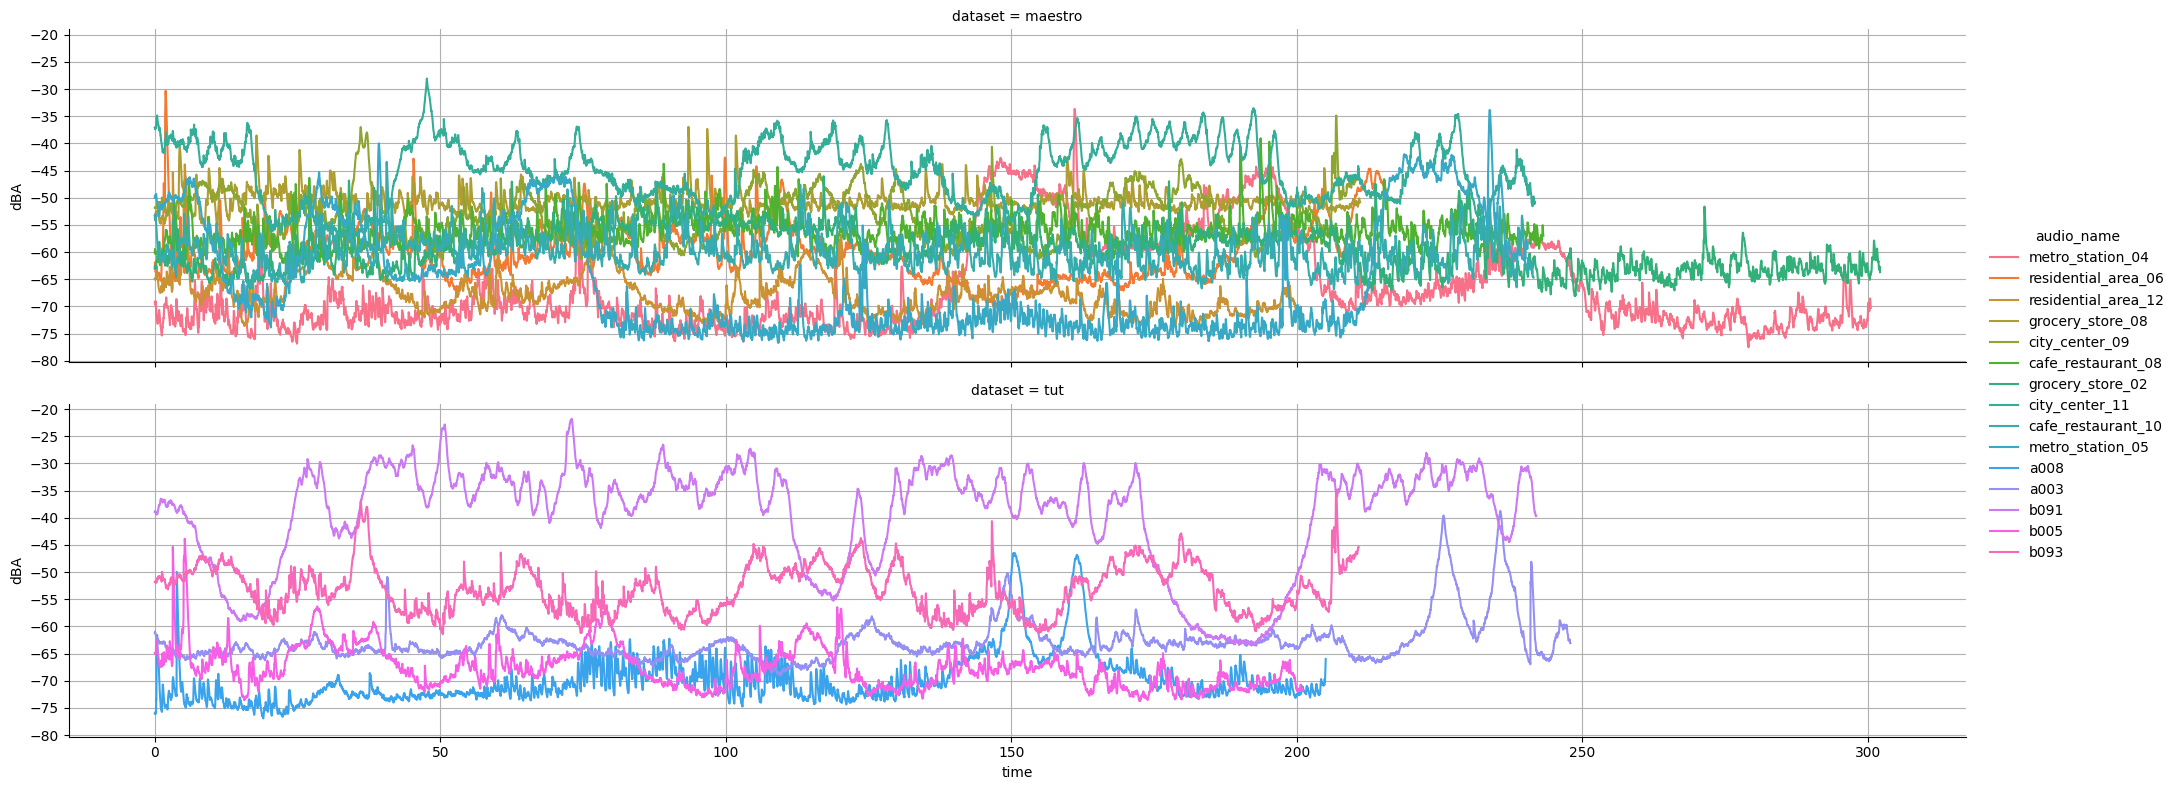

In [206]:

def plot_soundlevels(sl, value='dBA'):
    from matplotlib.ticker import MultipleLocator
    
    d = sl.reset_index()
    print(d.columns)
    d['time'] = d.time / pandas.Timedelta(seconds=1)
    
    g = seaborn.relplot(kind='line',
                        data=d,
                        x='time',
                        y=value,
                        hue='audio_name',
                        row='dataset',
                        aspect=5,
                        height=4)
    
    for ax in g.axes.flatten():
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.grid()
    
    return g

plot_soundlevels(ss)
    


In [205]:

from src.features.soundlevel import compute_background

sb = ss.groupby(['dataset', 'audio_name']).dBA.apply(compute_background)
sb

/tmp/ipykernel_107770/1523376626.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sb = ss.groupby(['dataset', 'audio_name']).dBA.apply(compute_background)


level  background  \
dataset audio_name       time                                               
maestro metro_station_04 0 days 00:00:00           -69.184182         NaN   
                         0 days 00:00:00.031247166 -69.550782         NaN   
                         0 days 00:00:00.062494331 -69.669016         NaN   
                         0 days 00:00:00.093741497 -69.361939         NaN   
                         0 days 00:00:00.124988662 -68.984336         NaN   
...                                                       ...         ...   
tut     b093             0 days 00:03:30.699637188 -45.978123  -50.193548   
                         0 days 00:03:30.730884354 -45.756233  -50.166701   
                         0 days 00:03:30.762131519 -45.605983  -50.165971   
                         0 days 00:03:30.793378685 -45.639681  -49.897041   
                         0 days 00:03:30.824625850 -45.364127  -49.813683   

                                                       delta  
dataset audio_name       time                                 
maestro metro_station_04 0 days 00:00:00                 NaN  
                         0 days 00:00:00.031247166       NaN  
                         0 days 00:00:00.062494331       NaN  
                         0 days 00:00:00.093741497       NaN  
                         0 days 00:00:00.124988662       NaN  
...                                                      ...  
tut     b093             0 days 00:03:30.699637188  4.215425  
                         0 days 00:03:30.730884354  4.410467  
                         0 days 00:03:30.762131519  4.559988  
                         0 days 00:03:30.793378685  4.257361  
                         0 days 00:03:30.824625850  4.449556  

[112512 rows x 3 columns]

Index(['dataset', 'audio_name', 'time', 'level', 'background', 'delta'], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


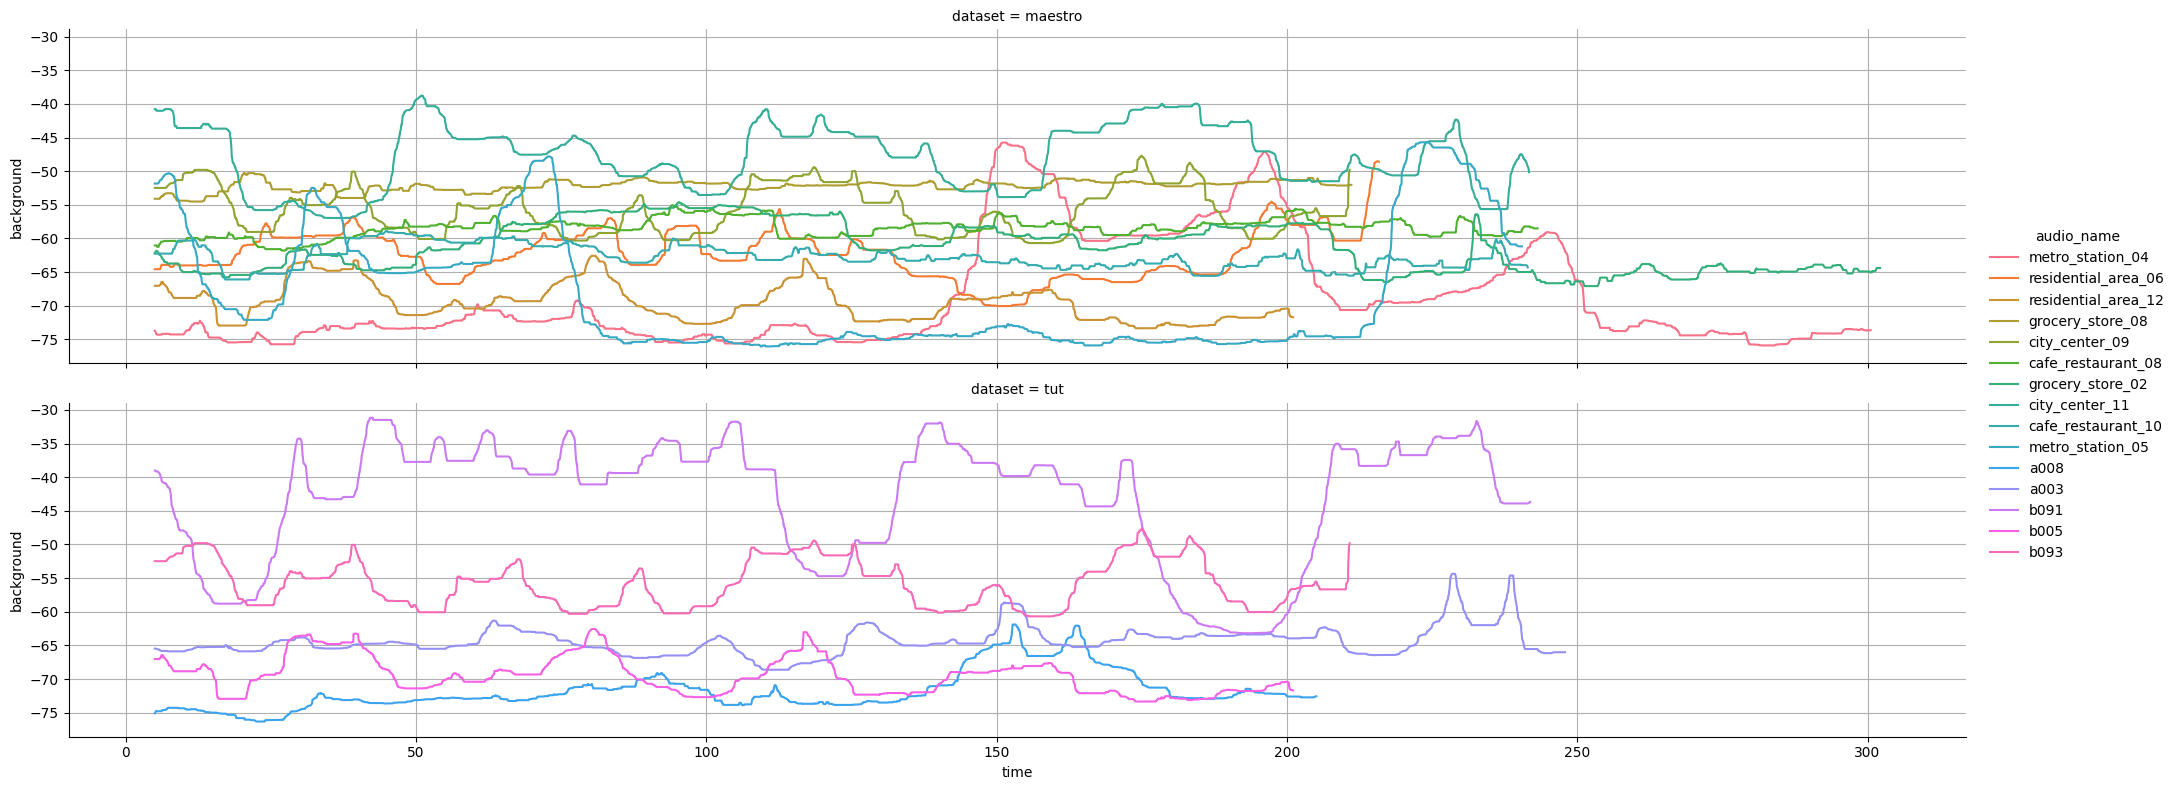

In [211]:
g = plot_soundlevels(sb, value='background')
g.savefig('soundlevels-background-maestro-tut.png')

Index(['dataset', 'audio_name', 'time', 'level', 'background', 'delta'], dtype='object')


/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


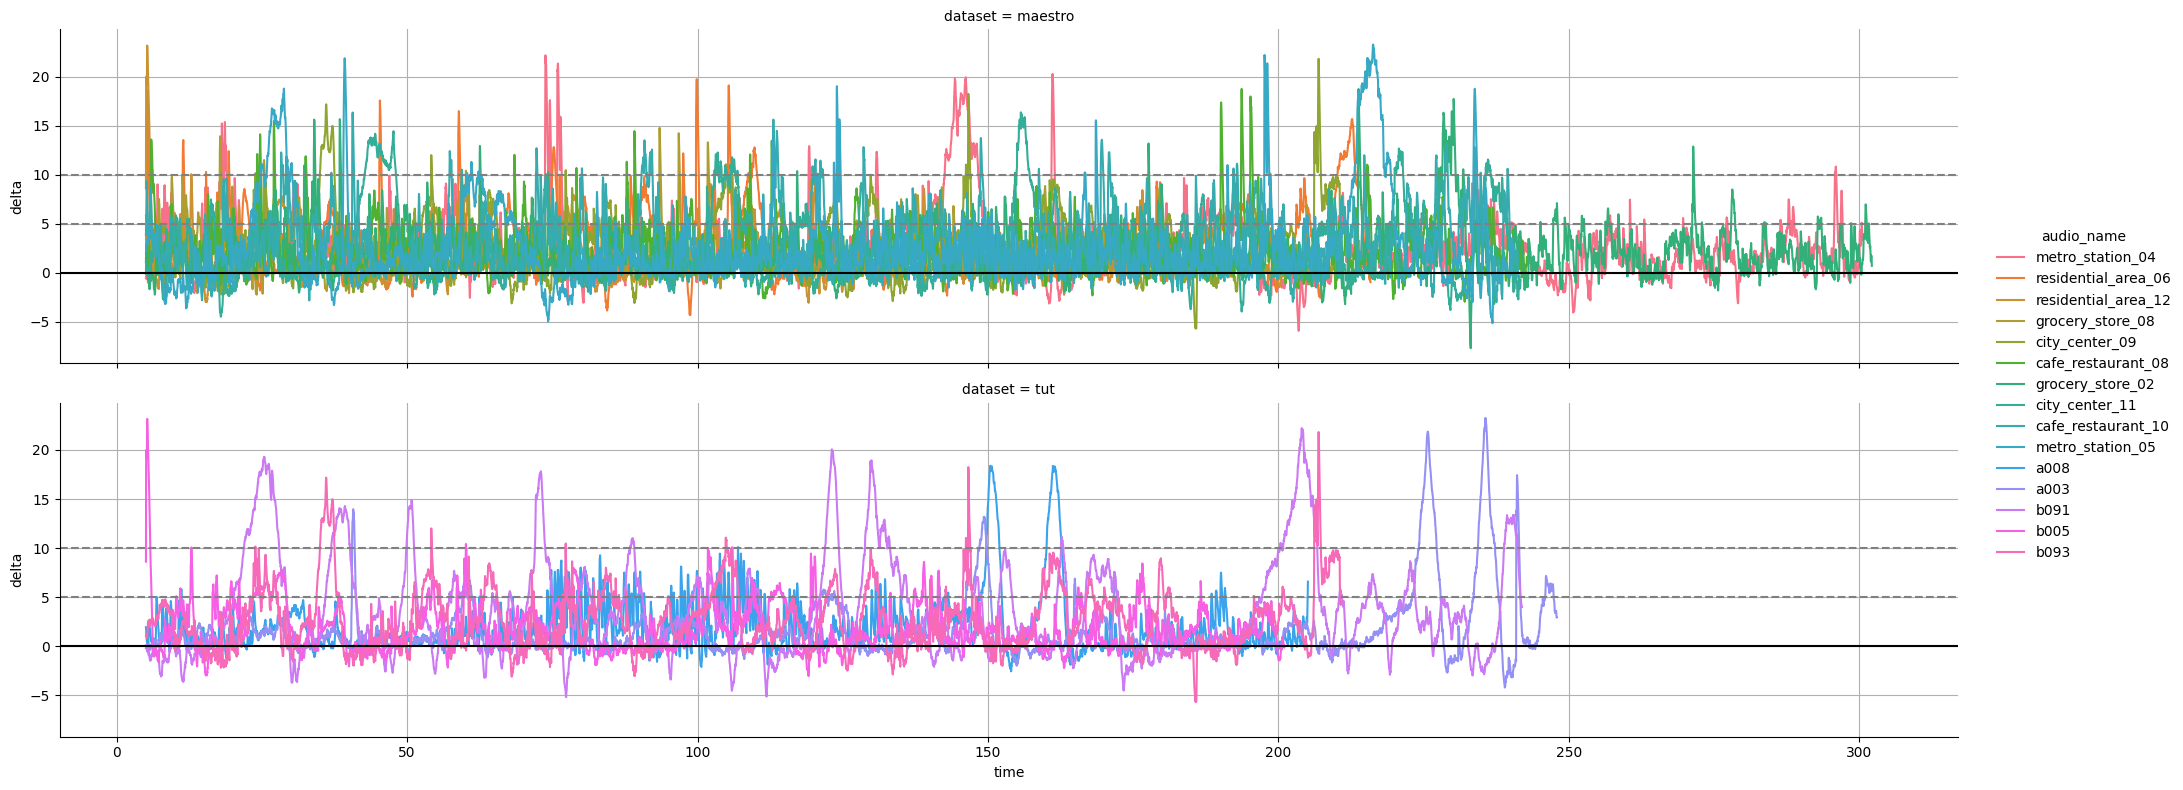

In [212]:
g = plot_soundlevels(sb, value='delta')
g.refline(y=0.0, ls='-', color='black')
g.refline(y=5.0, ls='--')
g.refline(y=10.0, ls='--')
g.savefig('soundlevels-eventdelta-maestro-tut.png')